In [1]:
import pandas as pd
import sys

pd.set_option('display.max_column', 100)
pd.set_option('display.max_row', 100)

sys.path.append('../../../fastai/')
sys.path.append('../../')

# xgboost
from xgb_learn.learner import *
from xgb_learn.dataset import *
from eda.simple import *

# embeddings
from fastai.column_data import *
from fastai.structured import *

from pathlib import *

In [9]:
dirs = list(Path('../../../data/talking').iterdir())
dirs

[PosixPath('../../../data/talking/train_sample.csv'),
 PosixPath('../../../data/talking/nn_small_full_data.feather'),
 PosixPath('../../../data/talking/test.csv'),
 PosixPath('../../../data/talking/train_small_data.feather'),
 PosixPath('../../../data/talking/train_small_data.csv.feather'),
 PosixPath('../../../data/talking/val_small_data.feather'),
 PosixPath('../../../data/talking/train.csv'),
 PosixPath('../../../data/talking/test_small_data.feather')]

### Preprocess

In [ ]:
sample = pd.read_csv('../../../data/talking/train_sample.csv')

In [8]:
train = pd.read_csv(dirs[-2], dtype={"ip":"int32", "app":"int16", "device":"int16", "os":"int16", "channel":"int16"})

In [10]:
test = pd.read_csv(dirs[2], dtype={"ip":"int32", "app":"int16", "device":"int16", "os":"int16", "channel":"int16"})

In [10]:
train.head(1)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0


In [11]:
test.head(1)

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00


In [12]:
train.shape, train.is_attributed.mean()

((184903890, 8), 0.002470721410998979)

In [21]:
def prep_data(data):
    # drop repeating columns
    nuniques = col_nunique(data)
    data.drop([c for c, i in nuniques if i == 1], 1, inplace=True)

    # extract time information
    data['click_time'] = pd.to_datetime(data['click_time'])
    data['click_timeHour'] = data.click_time.dt.hour
    data['click_timeDay'] = data.click_time.dt.day
    data.drop('click_time', 1, inplace=True)
    return data

# create train-val sets
def get_val_msk(data, day, hour):
    return (data.click_timeDay == day) & (data.click_timeHour >= hour)

In [14]:
# process train
train = prep_data(train)

In [22]:
test = prep_data(test)

In [27]:
# validation 24 hours last day 
train_msk = ((train.click_timeDay == 8) & (train.click_timeHour >= 9)) | \
((train.click_timeDay == 9) & (train.click_timeHour <= 8))
val_msk = ((train.click_timeDay == 9) & (train.click_timeHour >= 9) & (train.click_timeHour <= 15))

In [28]:
train_small_data = train[train_msk]
val_small_data = train[val_msk]

In [29]:
train_small_data.click_timeHour.unique()

array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8])

In [30]:
val_small_data.click_timeHour.unique()

array([ 9, 10, 11, 12, 13, 14, 15])

In [32]:
train_small_data.reset_index(drop=True, inplace=True)
val_small_data.reset_index(drop=True, inplace=True)

In [33]:
train_small_data.to_feather("../../../data/talking/train_small_data.csv.feather")
val_small_data.to_feather("../../../data/talking/val_small_data.feather")

#### Reduce Memory

In [34]:
def reduce_mem(data):
    data = data.astype(
        {"click_timeHour":"int8", 
         "click_timeDay":"int8", 
         "is_attributed":"int8"})
    data.drop("attributed_time", 1, inplace=True)
    return data

In [35]:
train_small_data = reduce_mem(train_small_data)
val_small_data = reduce_mem(val_small_data)

In [36]:
val_small_data.info("deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22928978 entries, 0 to 22928977
Data columns (total 8 columns):
ip                int32
app               int16
device            int16
os                int16
channel           int16
is_attributed     int8
click_timeHour    int8
click_timeDay     int8
dtypes: int16(4), int32(1), int8(3)
memory usage: 328.0 MB


In [37]:
train_small_data.info("deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63894895 entries, 0 to 63894894
Data columns (total 8 columns):
ip                int32
app               int16
device            int16
os                int16
channel           int16
is_attributed     int8
click_timeHour    int8
click_timeDay     int8
dtypes: int16(4), int32(1), int8(3)
memory usage: 914.0 MB


In [40]:
val_small_data.head(1)

,ip,app,device,os,channel,is_attributed,click_timeHour,click_timeDay
0,67040,3,1,19,211,0,9,9


In [39]:
train_small_data.head(1)

,ip,app,device,os,channel,is_attributed,click_timeHour,click_timeDay
0,206573,11,1,26,173,0,9,8


In [41]:
train_small_data.to_feather("../../../data/talking/train_small_data.csv.feather")
val_small_data.to_feather("../../../data/talking/val_small_data.feather")

In [43]:
train_small_data.is_attributed.mean(), val_small_data.is_attributed.mean()

(0.0023496243322725548, 0.0024151970489046655)

### Features

In [44]:
# target encodingu
def reg_mean_encoding(train, col, new_col, target, splits=10, seed=42):
    from sklearn.model_selection import KFold
    """ Computes regularize mean encoding.
        Use this to create mean encoding for training data
        
    Inputs:
        train: training dataframe
        col: a single column as string or list of columns to groupby 
        during mean target encoding
        new_col: name of new created column
        splits: splits to use for cv
    Returns:
        train: dataframe with new column added
    """
    # single column
    if isinstance(col, str):
        train[new_col] = 0
        #train["split_no"] = 0
        for split, (trn_idx, val_idx) in enumerate(KFold(splits, shuffle=True, random_state=seed).split(train)):
            groups = train.iloc[trn_idx].groupby(col)[target].mean()
            train.loc[val_idx, new_col] = train.loc[val_idx, col].map(groups)
            #train.loc[val_idx, "split_no"] = split

        train[new_col].fillna(train[new_col].mean(), inplace=True)

    # multiple column
    elif isinstance(col, list):
        train[new_col] = 0
        for trn_idx, val_idx in KFold(splits, shuffle=True, random_state=seed).split(train):
            groups = train.iloc[trn_idx].groupby(train[col].astype(object).sum(1))[target].mean()
            train.loc[val_idx, new_col] = train[col].astype(object).sum(1)[val_idx].map(groups)

        train[new_col].fillna(train[new_col].mean(), inplace=True)

    return train

In [45]:
def test_reg_mean_encoding(is_list=False):

    if not is_list:
        df = pd.DataFrame({'column': [1,1,1,1,1,1,2,2,2,2,2,2, 3],
        'target': [1,1,1,1,0,1,0,0,0,0,0,0,0]})

        new_df = pd.DataFrame({'column': [1,1,1,1,1,1,2,2,2,2,2,2, 3],
        'target': [1,1,1,1,0,1,0,0,0,0,0,0,0],
        'new_col': [0.800, 1.000, 0.750, 0.800, 1.000, 0.750, 0.000, 0.000,
        0.000, 0.000, 0.000, 0.000, 0.425]})
        
        assert (reg_mean_encoding(df, "column", "new_col", "target", splits=5, seed=42)\
                ["new_col"] == new_df["new_col"]).all()
        return "Test Passed"

    if is_list:
        return NotImplementedError

In [46]:
# create random target encodes
# try alternative : time dependent
random_encoding_cols =  ['ip', 'app', 'device', 'os', 'channel', 'click_timeHour']
#random_encoding_cols =  ['ip', 'app', 'device', 'os', 'channel']
for c in random_encoding_cols:
    train_small_data = reg_mean_encoding(train_small_data,
                                           c,
                                           f'random_mean_encode_{c}', 
                                           'is_attributed')

In [47]:
train_small_data.head(1)

,ip,app,device,os,channel,is_attributed,click_timeHour,click_timeDay,random_mean_encode_ip,random_mean_encode_app,random_mean_encode_device,random_mean_encode_os,random_mean_encode_channel,random_mean_encode_click_timeHour
0,206573,11,1,26,173,0,9,8,0.0,0.001439,0.001619,0.001105,0.00058,0.002507


In [79]:
def reg_mean_encoding_test(test, train, col, new_col, target):
    """ Computes target enconding for test data.
        Use this to create mean encoding for valdiation and test data
        Inputs:
            train: training dataframe to compute means
            test: training dataframe to create new column
            col: a single column as string or list of columns
            new_col: name of new created column
        Returns:
            test: dataframe with new column added
    This is similar to how we do validation
    """
    # YOUR CODE HERE
    if isinstance(col, str):
        test[new_col] = test[col].map(train.groupby(col)[target].mean())
        test[new_col].fillna(train[target].mean(), inplace=True)
    # multiple column
    elif isinstance(col, list):
        test[new_col] = test[col].astype(object).sum(1).map(train.groupby(train[col].astype(object).sum(1))[target].mean())
        test[new_col].fillna(train[target].mean(), inplace=True)

    return test

In [80]:
# create random target encodes
# try alternative : time dependen
random_encoding_cols =  ['ip', 'app', 'device', 'os', 'channel', 'click_timeHour']
for c in random_encoding_cols:
    val_small_data = reg_mean_encoding_test(val_small_data,
                                      train_small_data,
                                      c,
                                      f'random_mean_encode_{c}',
                                      'is_attributed')

In [81]:
train_small_data.to_feather("../../../data/talking/train_small_data.csv.feather")
val_small_data.to_feather("../../../data/talking/val_small_data.feather")

In [23]:
# create random target encodes
# try alternative : time dependen
random_encoding_cols =  ['ip', 'app', 'device', 'os', 'channel', 'click_timeHour']
for c in random_encoding_cols:
    test = reg_mean_encoding_test(test,
                                  pd.concat([train_small_data, val_small_data]),
                                  c,
                                  f'random_mean_encode_{c}',
                                  'is_attributed')

In [56]:
def dtype_transform(data):
    data = data.astype({"random_mean_encode_ip":"float32",
"random_mean_encode_app":"float32",
"random_mean_encode_device":"float32",
"random_mean_encode_os":"float32",
"random_mean_encode_channel":"float32",
"random_mean_encode_click_timeHour":"float32"})
    return data

In [24]:
train_small_data.shape, val_small_data.shape, test.shape

((63894895, 14), (22928978, 14), (18790469, 14))

In [60]:
train_small_data.shape, val_small_data.shape, test.shape

((63894895, 14), (22928978, 14), (18790469, 14))

In [57]:
train_small_data = dtype_transform(train_small_data)
val_small_data = dtype_transform(val_small_data)
test = dtype_transform(test)

In [61]:
train_small_data.to_feather("../../../data/talking/train_small_data.feather")
val_small_data.to_feather("../../../data/talking/val_small_data.feather")
test.to_feather("../../../data/talking/test_small_data.feather")

### XGBOOST

In [74]:
import gc

In [27]:
# 24 hour for training same hour for validation
train_small_data = pd.read_feather("../../../data/talking/train_small_data.feather")
val_small_data = pd.read_feather("../../../data/talking/val_small_data.feather")
test = pd.read_feather("../../../data/talking/test_small_data.feather")

In [28]:
usecols = ['ip', 'app', 'device', 'os', 'channel',
'click_timeDay', 'click_timeHour','random_mean_encode_ip',
'random_mean_encode_app', 'random_mean_encode_device',
'random_mean_encode_os', 'random_mean_encode_channel',
'random_mean_encode_click_timeHour']

In [29]:
trn_df = train_data[usecols]
val_df = val_data[usecols]
trn_y = train_data.is_attributed
val_y = val_data.is_attributed

In [79]:
del train_data
del val_data
gc.collect()

850

In [30]:
trn_df.head(1)

,ip,app,device,os,channel,click_timeDay,click_timeHour,random_mean_encode_ip,random_mean_encode_app,random_mean_encode_device,random_mean_encode_os,random_mean_encode_channel,random_mean_encode_click_timeHour
0,206573,11,1,26,173,8,9,0.0,0.001439,0.001619,0.001105,0.00058,0.002507


In [31]:
val_df.head(1)

,ip,app,device,os,channel,click_timeDay,click_timeHour,random_mean_encode_ip,random_mean_encode_app,random_mean_encode_device,random_mean_encode_os,random_mean_encode_channel,random_mean_encode_click_timeHour
0,67040,3,1,19,211,9,9,0.000456,0.000286,0.00149,0.001523,0.000357,0.002793


In [32]:
trn_df.dtypes

ip                                     int32
app                                    int16
device                                 int16
os                                     int16
channel                                int16
click_timeDay                           int8
click_timeHour                          int8
random_mean_encode_ip                float32
random_mean_encode_app               float32
random_mean_encode_device            float32
random_mean_encode_os                float32
random_mean_encode_channel           float32
random_mean_encode_click_timeHour    float32
dtype: object

In [33]:
xgb_md = XGBModelData(trn_df, val_df, trn_y, val_y)

In [34]:
dtrain, dval, evals = xgb_md.get_train_eval_ds()

In [35]:
trn_y.mean(), val_y.mean()

(0.0023496243322725548, 0.0024151970489046655)

In [36]:
xgb_learner = XGBLearner(dtrain, evals, True, 0.01, 'binary:logistic', 'auc', seed=7)

In [37]:
xgb_learner.params['nthread'] = 4

In [ ]:
xgb_learner.initialize()

In [ ]:
xgb_learner.params

In [ ]:
xgb_learner.num_rounds

In [ ]:
xgb_learner.random_search(100, verbose=True)

In [ ]:
# fit validation model
xgb_learner.fit_best_model(dtrain)

In [ ]:
xgb_learner.best_params

In [ ]:
xgb_learner.best_model.best_iteration

In [ ]:
sort_dict(xgb_learner.best_model.get_fscore())

In [ ]:
dtest = xgb.DMatrix(test.drop("click_id", 1)[dtrain.feature_names])

In [ ]:
preds = xgb_learner.best_model.predict(dtest)

In [ ]:
sub_df = pd.DataFrame({"click_id":test.click_id ,"is_attributed":preds})

In [ ]:
from IPython.display import FileLink

In [ ]:
sub_df.to_csv("xgb_unconverged.csv", index=False)

In [ ]:
FileLink("xgb_unconverged.csv")

In [ ]:
sub_df.head()

### EMBEDDING MODEL

In [2]:
torch.cuda.set_device(0)

In [20]:
train_small_data = pd.read_feather("../../../data/talking/train_small_data.feather")
val_small_data = pd.read_feather("../../../data/talking/val_small_data.feather")
test = pd.read_feather("../../../data/talking/test_small_data.feather")

# take samples from train small data and val small data
sample_ratio =  0.03
np.random.seed(7)
train_idx = np.random.choice(train_small_data.index, size=int(len(train_small_data)*sample_ratio), replace=False)
val_idx = np.random.choice(val_small_data.index, size=int(len(val_small_data)*sample_ratio), replace=False)

# create sample data
train_small_sample = train_small_data.iloc[train_idx].reset_index(drop=True, inplace=False)
val_small_sample = val_small_data.iloc[val_idx].reset_index(drop=True, inplace=False)

In [23]:
len(train_small_sample), len(val_small_sample)

(1916846, 687869)

In [28]:
np.unique(train_small_sample.click_timeDay), np.unique(train_small_sample.click_timeHour)

(array([8, 9], dtype=int8),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
       dtype=int8))

In [29]:
np.unique(val_small_sample.click_timeDay), np.unique(val_small_sample.click_timeHour)

(array([9], dtype=int8), array([ 9, 10, 11, 12, 13, 14, 15], dtype=int8))

In [31]:
train_small_sample.is_attributed.mean(), val_small_sample.is_attributed.mean()

(0.0023580402390176365, 0.002421972788423377)

In [32]:
usecols = ['ip', 'app', 'device', 'os', 'channel',
'click_timeDay', 'click_timeHour','random_mean_encode_ip',
'random_mean_encode_app', 'random_mean_encode_device',
'random_mean_encode_os', 'random_mean_encode_channel',
'random_mean_encode_click_timeHour']

In [33]:
train_small_data.head(1)

,ip,app,device,os,channel,is_attributed,click_timeHour,click_timeDay,random_mean_encode_ip,random_mean_encode_app,random_mean_encode_device,random_mean_encode_os,random_mean_encode_channel,random_mean_encode_click_timeHour
0,206573,11,1,26,173,0,9,8,0.0,0.001439,0.001619,0.001105,0.00058,0.002507


In [34]:
val_small_data.head(1)

,ip,app,device,os,channel,is_attributed,click_timeHour,click_timeDay,random_mean_encode_ip,random_mean_encode_app,random_mean_encode_device,random_mean_encode_os,random_mean_encode_channel,random_mean_encode_click_timeHour
0,67040,3,1,19,211,0,9,9,0.000833,0.000271,0.001618,0.00162,0.00039,0.002496


In [35]:
test.head(1)

,click_id,ip,app,device,os,channel,random_mean_encode_ip,random_mean_encode_app,random_mean_encode_device,random_mean_encode_os,random_mean_encode_channel,click_timeHour,click_timeDay,random_mean_encode_click_timeHour
0,0,5744,9,1,3,107,0.002208,0.001068,0.001585,0.000703,0.000541,4,10,0.002397


In [36]:
full_data = pd.concat([train_small_sample[usecols], val_small_sample[usecols], test[usecols]])

In [37]:
full_data.shape

(21395184, 13)

In [38]:
cats = ['ip', 'app', 'device', 'os', 'channel',
'click_timeDay', 'click_timeHour']

In [39]:
def create_emb_cols(data, cats):
    for c in cats:
        cat2emb = {v:k for k, v in enumerate(data[c].unique())}
        data[c] = data[c].map(cat2emb)
    return data

In [40]:
# convert cat levels to embedding values
full_data = create_emb_cols(full_data, cats)

In [41]:
# get cat sizes
cat_sz = [(c, len(full_data[c].unique())) for c in cats]

# create embedding sizes
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

# nconts
n_conts = len(full_data.columns) - len(cats)

In [44]:
full_data.reset_index(drop=True, inplace=True)

In [45]:
full_data.to_feather("../../../data/talking/nn_small_sample_full_data.feather")

In [46]:
train_nrows, val_nrows, test_nrows = train_small_sample.shape[0], val_small_sample.shape[0], test.shape[0]

In [47]:
train_nrows, val_nrows, test_nrows

(1916846, 687869, 18790469)

In [48]:
trn_df = full_data[:train_nrows]
val_df = full_data[train_nrows:train_nrows+val_nrows]
test_df = full_data[-test_nrows:]

In [49]:
assert trn_df.shape[0] == train_nrows
assert val_df.shape[0] == val_nrows
assert test_df.shape[0] == test_nrows

In [50]:
trn_y = train_small_sample.is_attributed
val_y = val_small_sample.is_attributed

In [51]:
assert trn_df.shape[0] == trn_y.shape[0]
assert val_df.shape[0] == val_y.shape[0]

In [52]:
# from data frames expects index 0,1, ...
val_df.reset_index(drop=True, inplace=True)
val_y.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [53]:
### Changed Validation Batch Size to be large enough for roc auc calculation

class ColumnarModelData(ModelData):
    def __init__(self, path, trn_ds, val_ds, bs, test_ds=None, shuffle=True):
        test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=1) if test_ds is not None else None
        super().__init__(path, DataLoader(trn_ds, bs, shuffle=shuffle, num_workers=1),
            DataLoader(val_ds, bs*50, shuffle=False, num_workers=1), test_dl) # increased validation batch size

    @classmethod
    def from_arrays(cls, path, val_idxs, xs, y, is_reg=True, is_multi=False, bs=64, test_xs=None, shuffle=True):
        ((val_xs, trn_xs), (val_y, trn_y)) = split_by_idx(val_idxs, xs, y)
        test_ds = PassthruDataset(*(test_xs.T), [0] * len(test_xs), is_reg=is_reg, is_multi=is_multi) if test_xs is not None else None
        return cls(path, PassthruDataset(*(trn_xs.T), trn_y, is_reg=is_reg, is_multi=is_multi),
                   PassthruDataset(*(val_xs.T), val_y, is_reg=is_reg, is_multi=is_multi),
                   bs=bs, shuffle=shuffle, test_ds=test_ds)

    @classmethod
    def from_data_frames(cls, path, trn_df, val_df, trn_y, val_y, cat_flds, bs, is_reg, is_multi, test_df=None):
        test_ds = ColumnarDataset.from_data_frame(test_df, cat_flds, None, is_reg, is_multi) if test_df is not None else None
        return cls(path, ColumnarDataset.from_data_frame(trn_df, cat_flds, trn_y, is_reg, is_multi),
                    ColumnarDataset.from_data_frame(val_df, cat_flds, val_y, is_reg, is_multi), bs, test_ds=test_ds)

    @classmethod
    def from_data_frame(cls, path, val_idxs, df, y, cat_flds, bs, is_reg=True, is_multi=False, test_df=None):
        ((val_df, trn_df), (val_y, trn_y)) = split_by_idx(val_idxs, df, y)
        return cls.from_data_frames(path, trn_df, val_df, trn_y, val_y, cat_flds, bs, is_reg, is_multi, test_df=test_df)

    def get_learner(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                    y_range=None, use_bn=False, **kwargs):
        model = MixedInputModel(emb_szs, n_cont, emb_drop, out_sz, szs, drops, y_range, use_bn, self.is_reg, self.is_multi)
        return StructuredLearner(self, StructuredModel(to_gpu(model)), opt_fn=optim.Adam, **kwargs)


In [59]:
# initialize model
model = MixedInputModel(emb_szs,
                        n_cont=n_conts,
                        emb_drop=0.5,
                        out_sz=2,
                        szs=[500,500],
                        drops=[0.5, 0.5],
                        is_reg=False,
                        is_multi=False).cuda()


bm = BasicModel(model, 'binary_classifier')

# initialize model data
bs = int(20000 * sample_ratio)
md = ColumnarModelData.from_data_frames('/tmp',
                                        trn_df,
                                        val_df,
                                        trn_y,
                                        val_y,
                                        cats,
                                        bs, False, False, test_df=test_df)

# initialize learner
learn = StructuredLearner(md, bm)

In [60]:
from sklearn.metrics import roc_auc_score

In [61]:
learn.lr_find()

 97%|█████████▋| 3085/3195 [01:29<00:03, 34.51it/s, loss=0.237]  

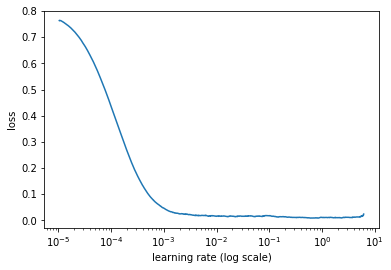

In [62]:
learn.sched.plot()

In [64]:
# auc metric
def auc(preds, targs):
    score = roc_auc_score(to_np(targs), to_np(preds)[:, 1])
    return score

In [65]:
learn.metrics = [accuracy, auc]

In [66]:
# baseline accuracy
all_zeros = 1 - val_y.mean()
all_zeros

0.9975780272115766

In [70]:
lr = 4e-4
learn.fit(lr, 10, cycle_len=1, use_clr=(10,10))

  1%|          | 35/3195 [00:01<01:49, 28.83it/s, loss=0.0152]
epoch      trn_loss   val_loss   accuracy   auc                 
    0      0.014991   0.015012   0.997578   0.816485  
    1      0.014337   0.014924   0.997578   0.822257            
    2      0.015538   0.014834   0.997578   0.827462            
    3      0.016206   0.014754   0.997578   0.832493            
    4      0.016884   0.01467    0.997578   0.837166            
    5      0.013156   0.014589   0.997578   0.841459            
    6      0.01633    0.014514   0.997578   0.845446            
    7      0.015245   0.014433   0.997578   0.849243            
    8      0.016451   0.014359   0.997578   0.852933            
    9      0.01442    0.014282   0.997578   0.856447            



[array([0.01428]), 0.9975780330939771, 0.8564473551407701]

In [71]:
learn.save("dnn10")

In [72]:
lr = 5e-4
learn.fit(lr, 10, cycle_len=1, use_clr=(10,10))

epoch      trn_loss   val_loss   accuracy   auc                 
    0      0.014958   0.014186   0.997578   0.860621  
    1      0.015658   0.014092   0.997578   0.864626            
    2      0.014366   0.014002   0.997578   0.868501            
    3      0.01458    0.013904   0.997578   0.872193            
    4      0.014714   0.013816   0.997578   0.875942            
    5      0.01477    0.013716   0.997578   0.879517            
    6      0.013545   0.013625   0.997578   0.883021            
    7      0.014144   0.01353    0.997578   0.886449            
    8      0.014379   0.013433   0.997578   0.889713            
    9      0.014118   0.013342   0.997578   0.892838            



[array([0.01334]), 0.9975780330939771, 0.8928382331015682]

In [73]:
learn.save("dnn20")

In [74]:
lr = 5e-4
learn.fit(lr, 20, cycle_len=1, use_clr=(10,10))

epoch      trn_loss   val_loss   accuracy   auc                 
    0      0.01339    0.013256   0.997578   0.895881  
    1      0.014159   0.013162   0.997578   0.898636            
    2      0.013238   0.013073   0.997578   0.901303            
    3      0.013467   0.012984   0.997578   0.903762            
    4      0.014744   0.012895   0.997578   0.906073            
    5      0.013131   0.012808   0.997578   0.908196            
    6      0.013462   0.012722   0.997578   0.910212            
    7      0.014847   0.012629   0.997578   0.912066             
    8      0.013659   0.012543   0.997578   0.913812            
    9      0.013837   0.012454   0.997578   0.915439            
    10     0.012012   0.012378   0.997578   0.917096            
    11     0.012226   0.012292   0.997578   0.918643            
    12     0.011907   0.0122     0.997578   0.920085            
    13     0.012948   0.012122   0.997578   0.921536            
    14     0.012465   0.012037   0

[array([0.01163]), 0.9975780330939771, 0.9281378247596579]

In [75]:
learn.save("dnn40")

In [76]:
lr = 6e-4
learn.fit(lr, 20, cycle_len=1, use_clr=(10,10))

epoch      trn_loss   val_loss   accuracy   auc                 
    0      0.012387   0.011538   0.997578   0.929138  
    1      0.012221   0.011444   0.997578   0.930094             
    2      0.011777   0.011354   0.997578   0.931017             
    3      0.011486   0.011268   0.997578   0.93189              
    4      0.011997   0.011181   0.997578   0.932681             
    5      0.012051   0.0111     0.997578   0.933449             
    6      0.011528   0.011029   0.997578   0.934175             
    7      0.010687   0.010957   0.997578   0.934884             
    8      0.010896   0.010887   0.997578   0.935564             
    9      0.011858   0.010816   0.997578   0.936181             
    10     0.009855   0.010764   0.997578   0.936781             
    11     0.010872   0.010698   0.997578   0.937335             
    12     0.010709   0.010644   0.997578   0.937911             
    13     0.012428   0.010592   0.997578   0.938458             
    14     0.011206   

[array([0.01038]), 0.9975780330939771, 0.9415691011077135]

In [77]:
learn.save("dnn60")

In [80]:
lr = 1e-3
learn.fit(lr, 20, cycle_len=1, use_clr=(10,10))

  6%|▋         | 202/3195 [00:09<02:19, 21.47it/s, loss=0.00926]
epoch      trn_loss   val_loss   accuracy   auc                  
    0      0.010743   0.010323   0.997578   0.94265   
    1      0.009901   0.010301   0.997578   0.943435             
    2      0.009813   0.010278   0.997578   0.944148             
    3      0.01046    0.010253   0.997578   0.94489              
    4      0.010204   0.010225   0.997578   0.945516             
    5      0.010329   0.010212   0.997578   0.946086             
    6      0.009046   0.010204   0.997578   0.946733             
    7      0.010085   0.010177   0.997578   0.947265             
    8      0.01135    0.010166   0.997578   0.947804             
    9      0.009674   0.010143   0.997578   0.948393             
    10     0.009635   0.010136   0.997578   0.948869             
    11     0.009938   0.010112   0.997578   0.949326             
    12     0.010881   0.010091   0.997578   0.949765             
    13     0.009449   

[array([0.00999]), 0.9975780330939771, 0.9525932258754055]

In [81]:
learn.save("dnn80")

In [111]:
lr = 1e-2
learn.fit(lr, 20, cycle_len=1, use_clr=(10,10))

epoch      trn_loss   val_loss   accuracy   auc                  
    0      0.008836   0.009109   0.997037   0.965735  
    1      0.009108   0.00913    0.997014   0.965818             
    2      0.007781   0.009179   0.997013   0.965899             
    3      0.008752   0.009143   0.99702    0.965873             
    4      0.005962   0.009125   0.997007   0.9659               
    5      0.007955   0.009145   0.996995   0.966022             
    6      0.008203   0.009101   0.99701    0.966173             
    7      0.008144   0.009166   0.996976   0.966073             
    8      0.008694   0.009111   0.997001   0.96618              
    9      0.007688   0.009152   0.996982   0.966197             
    10     0.009655   0.009178   0.996976   0.966407             
    11     0.008674   0.009098   0.996991   0.966375             
    12     0.007857   0.009138   0.996983   0.966381             
    13     0.009446   0.00917    0.996973   0.966511             
    14     0.008341  

[array([0.00909]), 0.9970008848989561, 0.9667252440150078]

In [87]:
learn.save("dnn100")

In [98]:
preds = learn.predict(is_test=True)

In [104]:
is_attributed = np.exp(preds)[:, 1]

In [105]:
is_attributed[:5]

array([0.00055, 0.00064, 0.00008, 0.00021, 0.00004], dtype=float32)

In [106]:
sub_df = pd.DataFrame({"click_id":test["click_id"], "is_attributed":is_attributed})

In [107]:
sub_df.head()

,click_id,is_attributed
0,0,0.000553
1,1,0.000640
2,2,0.000085
3,3,0.000209
4,4,0.000043


In [109]:
sub_df.to_csv("dnn100_sub.csv", index=False)

In [110]:
FileLink("dnn100_sub.csv")

/home/ec2-user/github/deeplearning/talking_data/dnn100_sub.csv

In [ ]:
lr = 1e-2
learn.fit(lr, 20, cycle_len=1, use_clr=(10,10))

### FFM